<a href="https://colab.research.google.com/github/sanu1230/Academic-Project/blob/master/Mining_Classification_xgboost_3May.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement
Mining companies face problems regarding the impurities present in Ore. More the impurities poorer the ore. 
In this problem we have to classify the **Grade** (quality) of Iron ore at the end process based on Silica present. <br/> 
Grade 1- Supreme Quality<br/>
Grade 2- Good Quality<br/>
Grade 3- Average Quality<br/>
Grade 4- Poor Quality

### Installing required packages

In [ ]:
%%capture
!pip install pandas_profiling==2.5.0

In [ ]:
!pip freeze | grep pandas

pandas==0.25.3
pandas-datareader==0.8.1
pandas-gbq==0.11.0
pandas-profiling==2.5.0
sklearn-pandas==1.8.0


In [ ]:
!pip -q install lime
!pip -q install eli5
!pip -q install shap

## Import the required Libraries

In [ ]:
import pandas as pd
import pandas_profiling
import dask.dataframe as dd
pd.options.display.max_columns=False
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import lime
import eli5
import shap
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


## **Import the data set**

In [ ]:
from google.colab import files
files.upload()

{}

**Read the data with dask**

In [ ]:
%time
dask_train = dd.read_csv('Iron_mining.xls',decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()     # Reading data using dask

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


**Read the data using pandas** 

In [ ]:
%time
df=pd.read_csv('Iron_mining.xls',decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


In [ ]:
df.shape

(5000, 26)

In [ ]:
df.head()

,Unnamed: 0,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,grade
0,677134,2017-08-27 00:00:00,63.64,3.77,2409.63,473.908,379.6564666667,9.22212,1.6901400000000002,300.645,295.45799999999997,301.54200000000003,299.07099999999997,300.904,293.225,300.605,411.80699999999996,504.19199999999995,399.356,429.865,427.22,399.01199999999994,380.20599999999996,65.99,1.04,2
1,529548,2017-07-23 20:00:00,57.44,14.09,3495.86,514.526,396.18199999999996,9.79135,1.7230400000000001,250.028,250.683,248.112,295.5314085145,294.7101342844,250.11599999999999,247.1,391.533,424.436,400.81,493.259,467.586,482.836,519.243,65.95,1.6,2
2,88250,2017-04-12 17:00:00,56.77,11.98,2074.22,548.706,400.781,9.88895,1.7402900000000001,250.457,250.269,248.95,296.1734384164,302.6528399183,252.68599999999998,248.73,605.09,704.043,593.506,451.95300000000003,443.93,468.769,473.408,64.35,2.64,3
3,714298,2017-09-04 15:00:00,54.14,14.69,1122.4509565217,477.284,382.7133333333,9.46836,1.61796,299.475,308.325,297.949,300.029,298.075,302.343,292.639,397.824,595.765,400.61699999999996,342.079,422.61199999999997,594.885,391.319,64.25,2.3,3
4,710528,2017-09-03 18:00:00,55.99,15.13,3266.57,525.784,378.7435,9.81666,1.71947,301.465,303.307,299.475,294.1870792079,289.5262690139,358.421,331.56699999999995,626.692,584.185,594.794,205.167,334.202,361.733,321.123,64.69,3.02,4


## **Explore Data**

In [ ]:
del df['Unnamed: 0']                                                                     # Lets drop the unnamed column

In [ ]:
df.info()                                                                                # Check the info of the dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
date                            5000 non-null datetime64[ns]
% Iron Feed                     5000 non-null object
% Silica Feed                   5000 non-null object
Starch Flow                     5000 non-null object
Amina Flow                      5000 non-null object
Ore Pulp Flow                   5000 non-null object
Ore Pulp pH                     5000 non-null object
Ore Pulp Density                5000 non-null object
Flotation Column 01 Air Flow    5000 non-null object
Flotation Column 02 Air Flow    5000 non-null object
Flotation Column 03 Air Flow    5000 non-null object
Flotation Column 04 Air Flow    5000 non-null object
Flotation Column 05 Air Flow    5000 non-null object
Flotation Column 06 Air Flow    5000 non-null object
Flotation Column 07 Air Flow    5000 non-null object
Flotation Column 01 Level       5000 non-null object
Flotation Column 02 Level       5000 

## **Feature Extraction**
Extract Hour, Month and Day columns from Date column

In [ ]:
df['Hour']=df['date'].dt.hour
df['Month']=df['date'].dt.month
# this will only work when you have a data which is in date format
# convert the column to datetime and then do this

In [ ]:
df['dayofweek']=df['date'].dt.dayofweek

In [ ]:
df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,grade,Hour,Month,dayofweek
0,2017-08-27 00:00:00,63.64,3.77,2409.63,473.908,379.6564666667,9.22212,1.6901400000000002,300.645,295.45799999999997,301.54200000000003,299.07099999999997,300.904,293.225,300.605,411.80699999999996,504.19199999999995,399.356,429.865,427.22,399.01199999999994,380.20599999999996,65.99,1.04,2,0,8,6
1,2017-07-23 20:00:00,57.44,14.09,3495.86,514.526,396.18199999999996,9.79135,1.7230400000000001,250.028,250.683,248.112,295.5314085145,294.7101342844,250.11599999999999,247.1,391.533,424.436,400.81,493.259,467.586,482.836,519.243,65.95,1.6,2,20,7,6
2,2017-04-12 17:00:00,56.77,11.98,2074.22,548.706,400.781,9.88895,1.7402900000000001,250.457,250.269,248.95,296.1734384164,302.6528399183,252.68599999999998,248.73,605.09,704.043,593.506,451.95300000000003,443.93,468.769,473.408,64.35,2.64,3,17,4,2
3,2017-09-04 15:00:00,54.14,14.69,1122.4509565217,477.284,382.7133333333,9.46836,1.61796,299.475,308.325,297.949,300.029,298.075,302.343,292.639,397.824,595.765,400.61699999999996,342.079,422.61199999999997,594.885,391.319,64.25,2.3,3,15,9,0
4,2017-09-03 18:00:00,55.99,15.13,3266.57,525.784,378.7435,9.81666,1.71947,301.465,303.307,299.475,294.1870792079,289.5262690139,358.421,331.56699999999995,626.692,584.185,594.794,205.167,334.202,361.733,321.123,64.69,3.02,4,18,9,6


In [ ]:
df['dayofweek'].value_counts()                                                        # Dayofweek counts across the data set

4    735
0    732
2    718
6    716
5    710
3    708
1    681
Name: dayofweek, dtype: int64

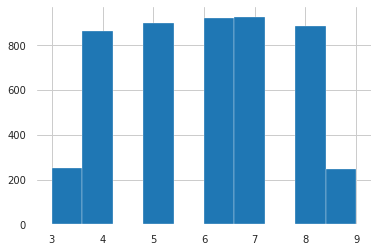

In [ ]:
df['Month'].hist()

In [ ]:
del df['date']                                                                  # We can delete date column as it's not required any longer

## **Null/Missing Values**

In [ ]:
print('Shape of the data \n',df.shape)
print('###############--------------')
print('Find Missing values if present\n',df.isnull().sum())
print('###############--------------')
print('Datatype\n',df.dtypes)

Shape of the data 
 (5000, 27)
###############--------------
Find Missing values if present
 % Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
grade                           0
Hour                            0
Month                           0
dayofweek              

In [ ]:
# int64 vs float ---> data science data type? 
# Numerical Discret vs Numerical Conti 

**Converting columns having object data type into numeric ones**

In [ ]:
new_df=df.iloc[:,:-5].astype(float)

In [ ]:
new_df1=pd.concat([new_df, df.iloc[:,-4:]], axis=1)                             # Merging all the numeric columns

In [ ]:
round(new_df1.head(),2)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,grade,Hour,Month,dayofweek
0,63.64,3.77,2409.63,473.91,379.66,9.22,1.69,300.64,295.46,301.54,299.07,300.90,293.23,300.60,411.81,504.19,399.36,429.86,427.22,399.01,380.21,65.99,2,0,8,6
1,57.44,14.09,3495.86,514.53,396.18,9.79,1.72,250.03,250.68,248.11,295.53,294.71,250.12,247.10,391.53,424.44,400.81,493.26,467.59,482.84,519.24,65.95,2,20,7,6
2,56.77,11.98,2074.22,548.71,400.78,9.89,1.74,250.46,250.27,248.95,296.17,302.65,252.69,248.73,605.09,704.04,593.51,451.95,443.93,468.77,473.41,64.35,3,17,4,2
3,54.14,14.69,1122.45,477.28,382.71,9.47,1.62,299.48,308.32,297.95,300.03,298.08,302.34,292.64,397.82,595.76,400.62,342.08,422.61,594.88,391.32,64.25,3,15,9,0
4,55.99,15.13,3266.57,525.78,378.74,9.82,1.72,301.46,303.31,299.48,294.19,289.53,358.42,331.57,626.69,584.18,594.79,205.17,334.20,361.73,321.12,64.69,4,18,9,6


In [ ]:
new_df1.head()

## **Descriptive Statistics of the data set**

In [ ]:
new_df1.describe().T

,count,mean,std,min,25%,50%,75%,max
% Iron Feed,5000.0,56.287182,5.123272,42.740000,52.670000,55.990000,59.660000,65.780000
% Silica Feed,5000.0,14.660398,6.736497,1.310000,8.990000,14.090000,19.580000,33.400000
Starch Flow,5000.0,2885.549793,1226.564669,0.926983,2077.735156,3022.215000,3748.682500,6294.080000
Amina Flow,5000.0,487.692110,92.871891,242.160938,428.023750,504.115000,554.013750,736.939876
Ore Pulp Flow,5000.0,397.470851,9.570733,376.310000,394.331250,399.288500,402.819500,418.638000
Ore Pulp pH,5000.0,9.771589,0.388677,8.753376,9.522980,9.802825,10.042600,10.807700
Ore Pulp Density,5000.0,1.679455,0.069558,1.519884,1.646155,1.697062,1.726485,1.848503
Flotation Column 01 Air Flow,5000.0,280.657171,29.216536,175.955087,250.286500,299.359500,300.146000,368.932750
Flotation Column 02 Air Flow,5000.0,277.157805,29.926332,177.130000,250.414750,296.042000,300.686000,366.708000
Flotation Column 03 Air Flow,5000.0,281.650409,28.057315,177.192455,250.973500,298.696500,300.435500,310.301000


**Pandas profiling**

In [ ]:
report=pandas_profiling.ProfileReport(new_df1, minimal=True)
report.to_file("mining_data.html")

In [ ]:
from IPython.display import display, HTML
display(HTML(open('mining_data.html').read()))

Number of variables,26
Number of observations,5000
Missing cells,0
Missing cells (%),0.0%
Duplicate rows,0
Duplicate rows (%),0.0%
Total size in memory,1.0 MiB
Average record size in memory,216.0 B
NUM,25
CAT,1
Analysis started,2020-07-20 13:22:42.229664


## **Correlation plot**

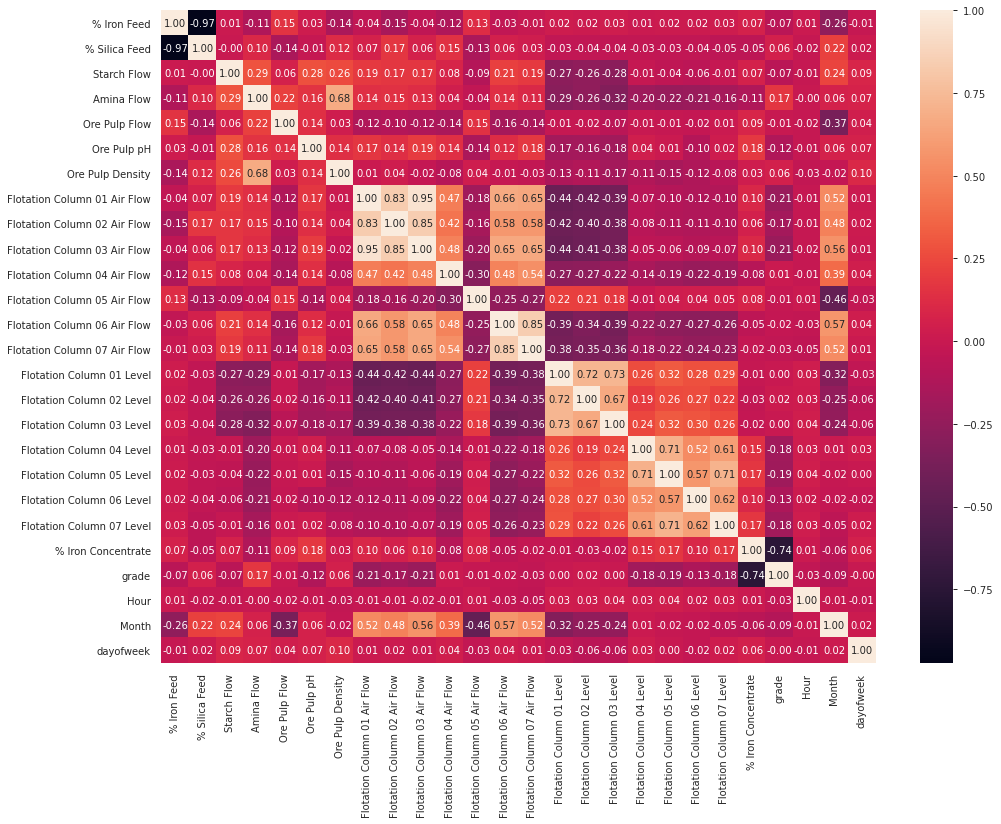

In [ ]:

plt.figure(figsize=[16,12])
sns.heatmap(new_df1.corr(), annot=True, fmt='.2f')
plt.show()

# EDA

## **Boxplot:**<br/> Check outliers across the variables

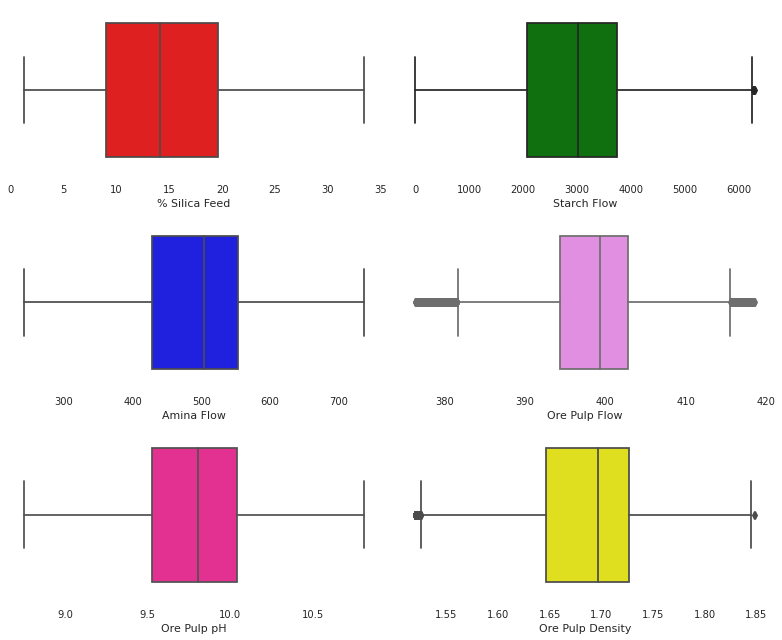

In [ ]:
# Checking the box plot of the first 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.boxplot(new_df1.iloc[:,1],color='r')
plt.subplot(322)
sns.boxplot(new_df1.iloc[:,2],color='g')
plt.subplot(323)
sns.boxplot(new_df1.iloc[:,3],color='b')
plt.subplot(324)
sns.boxplot(new_df1.iloc[:,4],color='violet')
plt.subplot(325)
sns.boxplot(new_df1.iloc[:,5],color='deeppink')
plt.subplot(326)
sns.boxplot(new_df1.iloc[:,6],color='yellow')
plt.tight_layout()
plt.show()

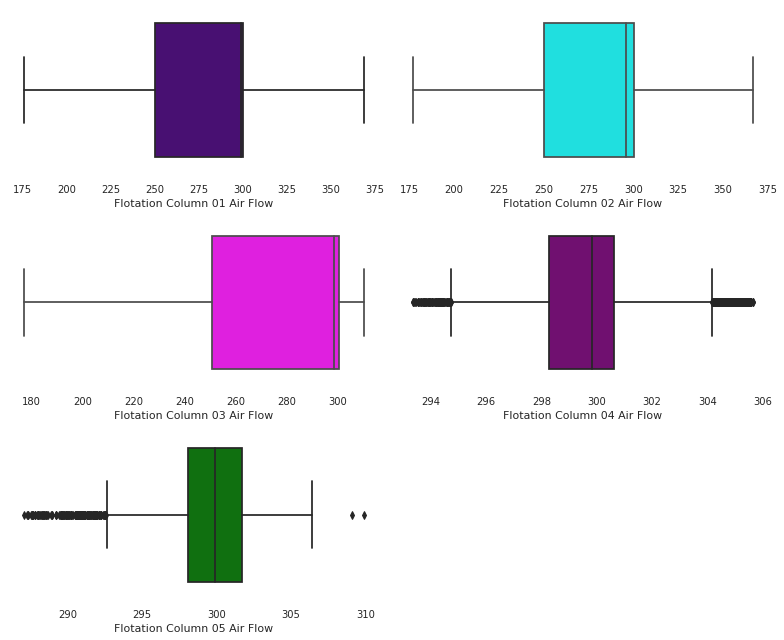

In [ ]:
# Checking the box plot of the next 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.boxplot(new_df1.iloc[:,7],color='indigo')
plt.subplot(322)
sns.boxplot(new_df1.iloc[:,8],color='cyan')
plt.subplot(323)
sns.boxplot(new_df1.iloc[:,9],color='magenta')
plt.subplot(324)
sns.boxplot(new_df1.iloc[:,10],color='purple')
plt.subplot(325)
sns.boxplot(new_df1.iloc[:,11],color='green')
plt.tight_layout()
plt.show()

**Observation** : From the quartile division, it is pretty evident that data points across the vairiables are consistent, i.e. no influence of outliers, though standard deviation in most of the variables is large. 

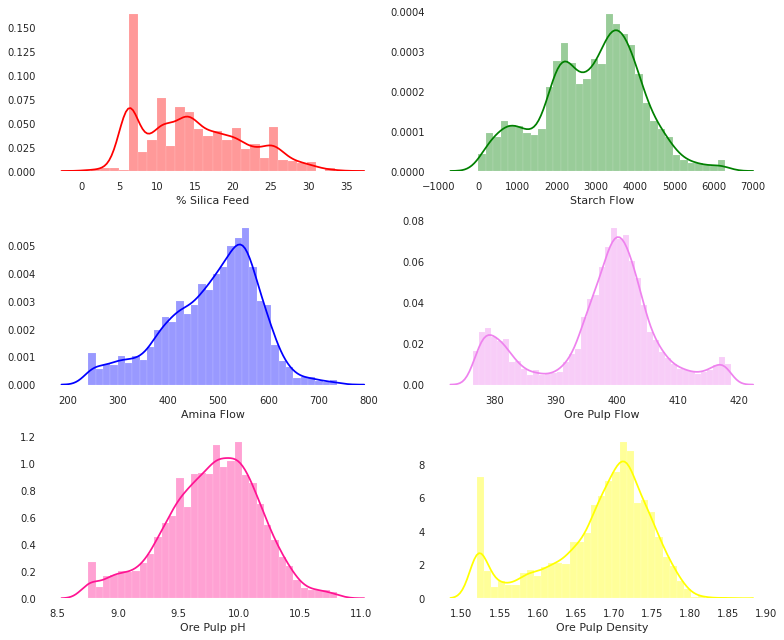

In [ ]:
# Checking the histigram of the first 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.distplot(new_df1.iloc[:,1],color='r')
plt.subplot(322)
sns.distplot(new_df1.iloc[:,2],color='g')
plt.subplot(323)
sns.distplot(new_df1.iloc[:,3],color='b')
plt.subplot(324)
sns.distplot(new_df1.iloc[:,4],color='violet')
plt.subplot(325)
sns.distplot(new_df1.iloc[:,5],color='deeppink')
plt.subplot(326)
sns.distplot(new_df1.iloc[:,6],color='yellow')
plt.tight_layout()
plt.show()

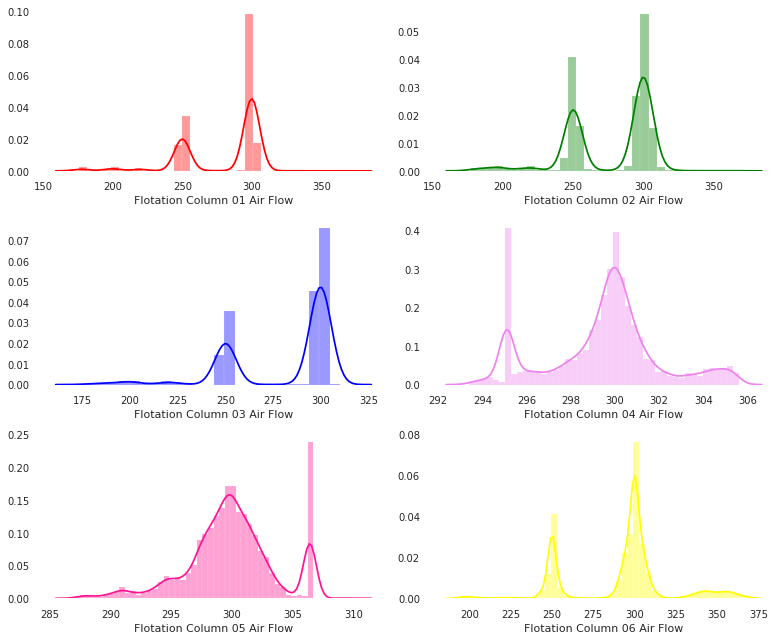

In [ ]:
# Checking the histogram of the next 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.distplot(new_df1.iloc[:,7],color='r')
plt.subplot(322)
sns.distplot(new_df1.iloc[:,8],color='g')
plt.subplot(323)
sns.distplot(new_df1.iloc[:,9],color='b')
plt.subplot(324)
sns.distplot(new_df1.iloc[:,10],color='violet')
plt.subplot(325)
sns.distplot(new_df1.iloc[:,11],color='deeppink')
plt.subplot(326)
sns.distplot(new_df1.iloc[:,12],color='yellow')
plt.tight_layout()
plt.show()

In [ ]:
new_df1['grade'].value_counts()                                                 # Frequency of each of 4 categories

2    2437
3    1285
4    1258
1      20
Name: grade, dtype: int64

**Creating the features and the labels**

In [ ]:
y=new_df1.loc[:,'grade']
new_df1.drop(['grade'], axis=1,inplace=True)
x=new_df1

In [ ]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,grade,Hour,Month,dayofweek
0,63.64,3.77,2409.63,473.908,379.6564666667,9.22212,1.6901400000000002,300.645,295.45799999999997,301.54200000000003,299.07099999999997,300.904,293.225,300.605,411.80699999999996,504.19199999999995,399.356,429.865,427.22,399.01199999999994,380.20599999999996,65.99,1.04,2,0,8,6
1,57.44,14.09,3495.86,514.526,396.18199999999996,9.79135,1.7230400000000001,250.028,250.683,248.112,295.5314085145,294.7101342844,250.11599999999999,247.1,391.533,424.436,400.81,493.259,467.586,482.836,519.243,65.95,1.6,2,20,7,6
2,56.77,11.98,2074.22,548.706,400.781,9.88895,1.7402900000000001,250.457,250.269,248.95,296.1734384164,302.6528399183,252.68599999999998,248.73,605.09,704.043,593.506,451.95300000000003,443.93,468.769,473.408,64.35,2.64,3,17,4,2
3,54.14,14.69,1122.4509565217,477.284,382.7133333333,9.46836,1.61796,299.475,308.325,297.949,300.029,298.075,302.343,292.639,397.824,595.765,400.61699999999996,342.079,422.61199999999997,594.885,391.319,64.25,2.3,3,15,9,0
4,55.99,15.13,3266.57,525.784,378.7435,9.81666,1.71947,301.465,303.307,299.475,294.1870792079,289.5262690139,358.421,331.56699999999995,626.692,584.185,594.794,205.167,334.202,361.733,321.123,64.69,3.02,4,18,9,6


**Dummy encode the categorical columns**

In [ ]:
cols=['Hour','Month','dayofweek']                                                     # These are the categorical columns
cat_cols=x[cols]
cat_cols=cat_cols.astype(str)

In [ ]:
dummies=pd.get_dummies(cat_cols,drop_first=True)

In [ ]:
dummies.head()

,Hour_1,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_2,Hour_20,Hour_21,Hour_22,Hour_23,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
x = x.drop(x[cols], 1)
input_features=pd.concat([x, dummies],axis=1)                                  # Concat the dummy variables with x(Input features)

In [ ]:
input_features.shape                                                             # Now we have 5000 rows and 60 columns

(5000, 57)

In [ ]:
input_features.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,Hour_1,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_2,Hour_20,Hour_21,Hour_22,Hour_23,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,63.64,3.77,2409.630000,473.908,379.656467,9.22212,1.69014,300.645,295.458,301.542,299.071000,300.904000,293.225,300.605,411.807,504.192,399.356,429.865,427.220,399.012,380.206,65.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,57.44,14.09,3495.860000,514.526,396.182000,9.79135,1.72304,250.028,250.683,248.112,295.531409,294.710134,250.116,247.100,391.533,424.436,400.810,493.259,467.586,482.836,519.243,65.95,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,56.77,11.98,2074.220000,548.706,400.781000,9.88895,1.74029,250.457,250.269,248.950,296.173438,302.652840,252.686,248.730,605.090,704.043,593.506,451.953,443.930,468.769,473.408,64.35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,54.14,14.69,1122.450957,477.284,382.713333,9.46836,1.61796,299.475,308.325,297.949,300.029000,298.075000,302.343,292.639,397.824,595.765,400.617,342.079,422.612,594.885,391.319,64.25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,55.99,15.13,3266.570000,525.784,378.743500,9.81666,1.71947,301.465,303.307,299.475,294.187079,289.526269,358.421,331.567,626.692,584.185,594.794,205.167,334.202,361.733,321.123,64.69,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


**Train-Test split for training and validation**

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(input_features,y,test_size=0.2,random_state=1234)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 57)
(1000, 57)
(4000,)
(1000,)


## Performing ML models

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=101)

In [ ]:
lr_model=lr.fit(x_train,y_train)

In [ ]:
lr_pred=lr_model.predict(x_test)

0.527
********************************************
Confusion matrix


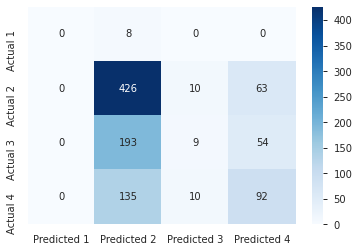

**********************************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.56      0.85      0.68       499
           3       0.31      0.04      0.06       256
           4       0.44      0.39      0.41       237

    accuracy                           0.53      1000
   macro avg       0.33      0.32      0.29      1000
weighted avg       0.46      0.53      0.45      1000



In [ ]:
print(metrics.accuracy_score(y_test,lr_pred))
print('********************************************')
print('Confusion matrix')
lr_cfm=metrics.confusion_matrix(y_test, lr_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(lr_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('**********************************************')
print(metrics.classification_report(y_test,lr_pred))

**Decision Tree classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 50, min_samples_leaf =3, random_state=101,class_weight='balanced')
# from 13 to 15 -- class 1 goes 0 
# from 10-13 -- class 1 is atleast picking one example 

In [ ]:
dt_model=dt.fit(x_train,y_train)
dt_pred=dt_model.predict(x_test)

0.734
***************************************
Confusion matrix


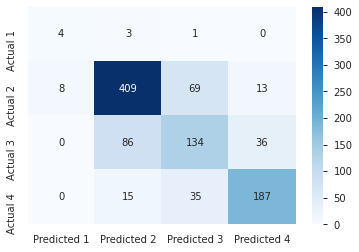

****************************************
              precision    recall  f1-score   support

           1       0.33      0.50      0.40         8
           2       0.80      0.82      0.81       499
           3       0.56      0.52      0.54       256
           4       0.79      0.79      0.79       237

    accuracy                           0.73      1000
   macro avg       0.62      0.66      0.64      1000
weighted avg       0.73      0.73      0.73      1000



In [ ]:
print(metrics.accuracy_score(y_test,dt_pred))
print('***************************************')
print('Confusion matrix')
dt_cfm=metrics.confusion_matrix(y_test, dt_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(dt_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('****************************************')
print(metrics.classification_report(y_test,dt_pred))

**RandomForest with Grid Search**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(oob_score=True)

#### GridSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'n_estimators': range(5,20,3),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [5,10,20,30],
              'min_samples_split':[2,5,10],
              'criterion':['entropy'],
              'min_samples_leaf':[1,2,4]}

rf = RandomForestClassifier(class_weight='balanced_subsample')

rf_gs = RandomizedSearchCV(rf, random_grid, cv = 5, n_jobs=-1, verbose=2)

rf_gs.fit(x_train, y_train)
y_pred = rf_gs.predict(x_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.5s finished


In [ ]:
rf_gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=14, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

0.792
*******************************************
Confusion matrix


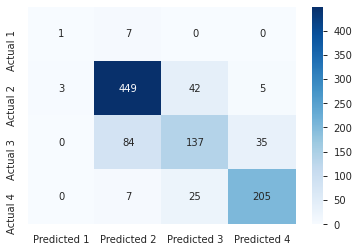

********************************************
              precision    recall  f1-score   support

           1       0.25      0.12      0.17         8
           2       0.82      0.90      0.86       499
           3       0.67      0.54      0.60       256
           4       0.84      0.86      0.85       237

    accuracy                           0.79      1000
   macro avg       0.64      0.61      0.62      1000
weighted avg       0.78      0.79      0.78      1000



In [ ]:
print(metrics.accuracy_score(y_test,y_pred))
print('*******************************************')
print('Confusion matrix')
rf_cfm=metrics.confusion_matrix(y_test, y_pred)

lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(rf_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('********************************************')
print(metrics.classification_report(y_test,y_pred))

In [ ]:
# Upscale the class 1 - which is to replicate values of class in overall data 
# https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_illustration_generation_sample.html#sphx-glr-auto-examples-over-sampling-plot-illustration-generation-sample-py

## Performing Boosting Models

**XGBoost**<br/>

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(num_class = 4,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                          max_depth=30,
                           seed=42) 

In [ ]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=1, verbosity=1)

In [ ]:
xgboost_pred=xgb_model.predict(x_test)

0.825
************
Confusion matrix


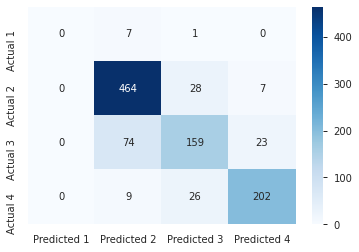

************
 Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.84      0.93      0.88       499
           3       0.74      0.62      0.68       256
           4       0.87      0.85      0.86       237

    accuracy                           0.82      1000
   macro avg       0.61      0.60      0.60      1000
weighted avg       0.81      0.82      0.82      1000



In [ ]:
print(metrics.accuracy_score(y_test,xgboost_pred))
print('************')
print('Confusion matrix')
xgboost_cm=metrics.confusion_matrix(y_test, xgboost_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(xgboost_cm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('************\n Classification report')
print(metrics.classification_report(y_test,xgboost_pred))

**XgBoost with Grid Search**

In [ ]:
xgb_gs_clf = XGBClassifier(num_class = 4,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42)                         
                        
param_grid = {"max_depth": [10,15,20,30],
              "n_estimators": range(5,20,2) , 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.01,0.05]}
#              "min_child_weight": [5,10], 
#              "colsample_bytree": [0.4,0.8], 
#              "subsample": [0.50,0.85]} 

grid_search = RandomizedSearchCV(xgb_gs_clf, 
                           param_grid,
                           cv = 5,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='mlogloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None, num_class=4,
                                           objective='multi:softprob',
                                           random_s...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=42, silent=None, subsample=1,
                       

In [ ]:
xgboost_y_pred=grid_search.predict(x_test)                                      # Validating the model by predicting the test data

0.786
*************************************************
Confusion matrix


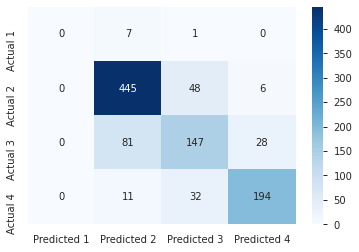

***************************************************
 Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.82      0.89      0.85       499
           3       0.64      0.57      0.61       256
           4       0.85      0.82      0.83       237

    accuracy                           0.79      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.77      0.79      0.78      1000



In [ ]:
print(metrics.accuracy_score(y_test,xgboost_y_pred))
print('*************************************************')
print('Confusion matrix')
xgboost_cfm=metrics.confusion_matrix(y_test, xgboost_y_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(xgboost_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,xgboost_y_pred))

In [ ]:
# Try changing the scoring function and Loss function if you have imbalance in your class
 # minimize for F1  https://scikit-learn.org/stable/modules/model_evaluation.html#

**LightGBM**

In [ ]:
import lightgbm as lgb

d_train= lgb.Dataset(x_train, label = y_train)                                        # LightGBM dataset format

In [ ]:
params = {}
params['learning_rate'] = 0.01                                             # Learning rate
params['boosting_type'] = 'gbdt'                                           # gbdt = gradient boosted decision tree
params['objective'] = 'multiclass'                                         # Multi class classification
params['metric'] = 'multi_logloss'
params['num_classes'] = 5
#params['sub_feature'] = 0.5
#params['min_data'] = 50
#params['max_depth'] = 10


clf = lgb.train(params, d_train)                                                      # Training the model for 10 iterations

In [ ]:
#Prediction
y_pred=clf.predict(x_test)

In [ ]:
predictions = []

for x in y_pred:
    predictions.append(np.argmax(x))

In [ ]:
lgb_y_pred = np.array(predictions)

0.758
*************************************************
Confusion matrix


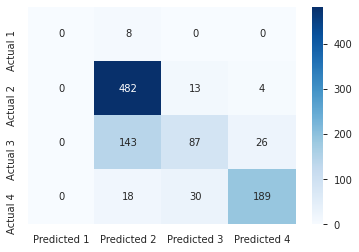

***************************************************
 Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.74      0.97      0.84       499
           3       0.67      0.34      0.45       256
           4       0.86      0.80      0.83       237

    accuracy                           0.76      1000
   macro avg       0.57      0.53      0.53      1000
weighted avg       0.75      0.76      0.73      1000



In [ ]:
print(metrics.accuracy_score(y_test,lgb_y_pred))
print('*************************************************')
print('Confusion matrix')
lgb_cfm=metrics.confusion_matrix(y_test, lgb_y_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(lgb_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,lgb_y_pred))

In [ ]:
y_train.value_counts()

2    1938
3    1029
4    1021
1      12
Name: grade, dtype: int64

# Model interpretability using Eli5 and SHAP

## Eli5

In [ ]:
eli5.show_weights(xgb_model, feature_names=x_train.columns.values)


Weight,Feature
0.1273,% Iron Concentrate
0.0338,Month_8
0.0304,Month_6
0.0271,Month_9
0.0254,Month_5
0.0238,Hour_19
0.0226,Hour_14
0.0224,Month_7
0.0208,Month_4
0.0206,Hour_1


In [ ]:
eli5.explain_prediction(xgb_model,x_test.iloc[1])

Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',\n              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=30,\n              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,\n              nthread=None, num_class=4, objective='multi:softprob',\n              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,\n              seed=42, silent=None, subsample=1, verbosity=1)", description='\nFeatures with largest coefficients per class.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[], neg=[FeatureWeight(feature='<BIAS>', weight=-3.726245203881178, std=None, value=1.0), FeatureWeight(feature='% Iron Concentrate', weight=-0.5618735885938091, std=None, value=64.94), FeatureWeight(feature='Starch Flow', weight=-0.11871355908135553, std=None, value=2199.62), FeatureWeight(feature='Hour_23', weight=-0.08557332465746072, std=None, value=0.0), FeatureWeight(feature='% Iron Feed', weight=-0.07986352746998397, std=None, value=55.94), FeatureWeight(feature='Flotation Column 06 Level', weight=-0.04904178304248563, std=None, value=406.087), FeatureWeight(feature='Ore Pulp pH', weight=-0.03791382432637658, std=None, value=9.51868), FeatureWeight(feature='Flotation Column 01 Air Flow', weight=-0.03535121316303769, std=None, value=299.893), FeatureWeight(feature='Flotation Column 03 Level', weight=-0.02767631069889516, std=None, value=440.978), FeatureWeight(feature='Flotation Column 07 Air Flow', weight=-0.02607475421959616, std=None, value=302.596), FeatureWeight(feature='Flotation Column 04 Air Flow', weight=-0.022443926349121263, std=None, value=299.47), FeatureWeight(feature='Month_5', weight=-0.020194268437396343, std=None, value=0.0), FeatureWeight(feature='Ore Pulp Flow', weight=-0.0191472037386683, std=None, value=394.2), FeatureWeight(feature='Flotation Column 06 Air Flow', weight=-0.015888476851302534, std=None, value=295.279), FeatureWeight(feature='% Silica Feed', weight=-0.012167893948873618, std=None, value=13.85), FeatureWeight(feature='Amina Flow', weight=-0.006078527358640576, std=None, value=439.407), FeatureWeight(feature='Flotation Column 01 Level', weight=-0.005297197229436404, std=None, value=453.596), FeatureWeight(feature='Flotation Column 05 Air Flow', weight=-0.0050879487492417885, std=None, value=299.843), FeatureWeight(feature='Hour_2', weight=-0.0015712777031395703, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.0032177593, score=-4.856203809500002, weighted_spans=None, heatmap=None), TargetExplanation(target=2, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.1211644766904756, std=None, value=1.0), FeatureWeight(feature='Ore Pulp Density', weight=0.2830197603938685, std=None, value=1.737

In [ ]:
eli5.explain_prediction(xgb_model,x_test.iloc[30])

Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',\n              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=30,\n              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,\n              nthread=None, num_class=4, objective='multi:softprob',\n              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,\n              seed=42, silent=None, subsample=1, verbosity=1)", description='\nFeatures with largest coefficients per class.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='% Iron Concentrate', weight=0.664158990946445, std=None, value=66.2), FeatureWeight(feature='Starch Flow', weight=0.3341698133522512, std=None, value=4283.34), FeatureWeight(feature='% Iron Feed', weight=0.09792428910210815, std=None, value=47.05), FeatureWeight(feature='Flotation Column 06 Level', weight=0.08972945143519553, std=None, value=336.23), FeatureWeight(feature='% Silica Feed', weight=0.042184913905162186, std=None, value=28.14)], neg=[FeatureWeight(feature='<BIAS>', weight=-3.726245203881178, std=None, value=1.0), FeatureWeight(feature='Ore Pulp Density', weight=-0.49667158470820494, std=None, value=1.7322), FeatureWeight(feature='Flotation Column 01 Level', weight=-0.15529474778131486, std=None, value=523.263), FeatureWeight(feature='Flotation Column 05 Air Flow', weight=-0.12692462806360244, std=None, value=299.716), FeatureWeight(feature='Ore Pulp pH', weight=-0.09636801785078697, std=None, value=9.98347), FeatureWeight(feature='Flotation Column 04 Air Flow', weight=-0.046961387981569305, std=None, value=300.183), FeatureWeight(feature='Amina Flow', weight=-0.041088454353030934, std=None, value=427.017), FeatureWeight(feature='Flotation Column 02 Air Flow', weight=-0.035330072444281393, std=None, value=298.878), FeatureWeight(feature='Flotation Column 01 Air Flow', weight=-0.027331944311910574, std=None, value=299.666), FeatureWeight(feature='Hour_2', weight=-0.020051766526068007, std=None, value=0.0), FeatureWeight(feature='Hour_23', weight=-0.013489430273390134, std=None, value=0.0), FeatureWeight(feature='Flotation Column 04 Level', weight=-0.01211665022893405, std=None, value=372.309), FeatureWeight(feature='Flotation Column 07 Level', weight=-0.011282877411566566, std=None, value=349.14099999999996), FeatureWeight(feature='dayofweek_5', weight=-0.00975717931380854, std=None, value=0.0), FeatureWeight(feature='Ore Pulp Flow', weight=-0.007798448921655306, std=None, value=392.389), FeatureWeight(feature='Month_5', weight=-0.007711561523785179, std=None, value=0.0), FeatureWeight(feature='Flotation Column 03 Air Flow', weight=-0.007686205678734452, std=None, value=302.17), FeatureWeight(feature='Month_8', weight=-0.0062956730374511

In [ ]:
y_test.iloc[30]

2

## SHAP

In [ ]:
import shap

In [ ]:
xgboost_explainer_shap=shap.TreeExplainer(xgb_model)

In [ ]:
y_test.iloc[1]

3

In [ ]:
print('Actual label\n', y_test.iloc[1])
print('******')
shap_values1 = xgboost_explainer_shap.shap_values(x_test.iloc[1])
data_to_predict1 = x_test.iloc[1]
shap.initjs()
shap.force_plot(xgboost_explainer_shap.expected_value[2], shap_values1[2], data_to_predict1)

Actual label
 3
******


In [ ]:
print('Actual label\n',y_test.iloc[30])
print('******')
shap_values30=xgboost_explainer_shap.shap_values(x_test.iloc[30])
data_to_predict30 = x_test.iloc[30]
shap.initjs()
shap.force_plot(xgboost_explainer_shap.expected_value[1],shap_values30[1],data_to_predict30)

Actual label
 2
******
